# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. These places, called **Points of Interest (POI)**  are not on the main trajectory of the cyclepath, but the bikers must deviate to reach them.

We assume that the bikers enter the cyclepath where it begins and finish the trip ath the end of the cyclepath. When they enter the battery is fully charged. Moreover, the bikers will make all possible deviations in order to visit all the POIs.







## Formulation

To support the formulation we make use of a graph with $2n+2$ nodes.
Nodes $s$ and $t$ represent the extremes of the cyclepath.

Nodes

*   $L = \{1,\ldots,n\}$:  locations along the cyclepath from which bikers deviate


*   $H = \{1',\ldots, n'\}$:  POIs that may host a charging station.

*   $\{s,t\}$: extremes of the cyclepath.

Arcs

*  $\{(i,i+1), (i+1, i) 1,\ldots,n \}$: arcs of the cyclepath in the two directions

*  $\{(i,i'), (i',i), i\in L, i'\in H\}$: arcs representing the deviations from the cyclepath

### Example of the graph
![picture](https://drive.google.com/file/d/1A4dSP-4K1E3jwaab4A8JT21TKD7FINaK/view?usp=drive_link)

### Parameters

*   $d_{i,i+1}, d_{i+1,i}, i=1,\ldots,n-1$: energy consumption between consecutive nodes,
*   $d_{i,i'}, d_{i',i}, i \in L, i'\in H$: energy consumption for the deviations
*   $c_i'$: cost of installing a charging station in site $i' \in H$
*   $\Delta$: maximum energy consumption between consecutive charging stations

We assume that $d_{s,1} d_{1,s} = d_{n,t} = d_{t,n} = 0$.
Note that the energy consumption on each arc can be different in the two directions, depending on the orography.








## Problem 1

Consider a biker that traverses the cyclepath from $s$ to $t$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.



## Problem 2

Consider a biker that traverses the cyclepath from $t$ to $s$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.

### Comments
Do you obtain the same solution? Why?

### Recommendation
The problems can be solved by a simple formulation. The solution of complex problems as the TSP is not necessary.
Do not use external libraries apart from those presented in class.



In [1]:
#import libraries

!pip install mip
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx

  Using cached cffi-1.15.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (446 kB)
  Attempting uninstall: cffi
    Found existing installation: cffi 1.15.1
    Uninstalling cffi-1.15.1:
      Successfully uninstalled cffi-1.15.1


## Solution Problem 1

In [3]:
#data PROBLEM 1

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0  # starting point---> punto precedente al quale voglio far girare l'algoritmo
t = n + 1  # destination---> punto successivo all'ultimo punto su cui voglio far girare l'algoritmo
consumption = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # consumption (in Wh) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

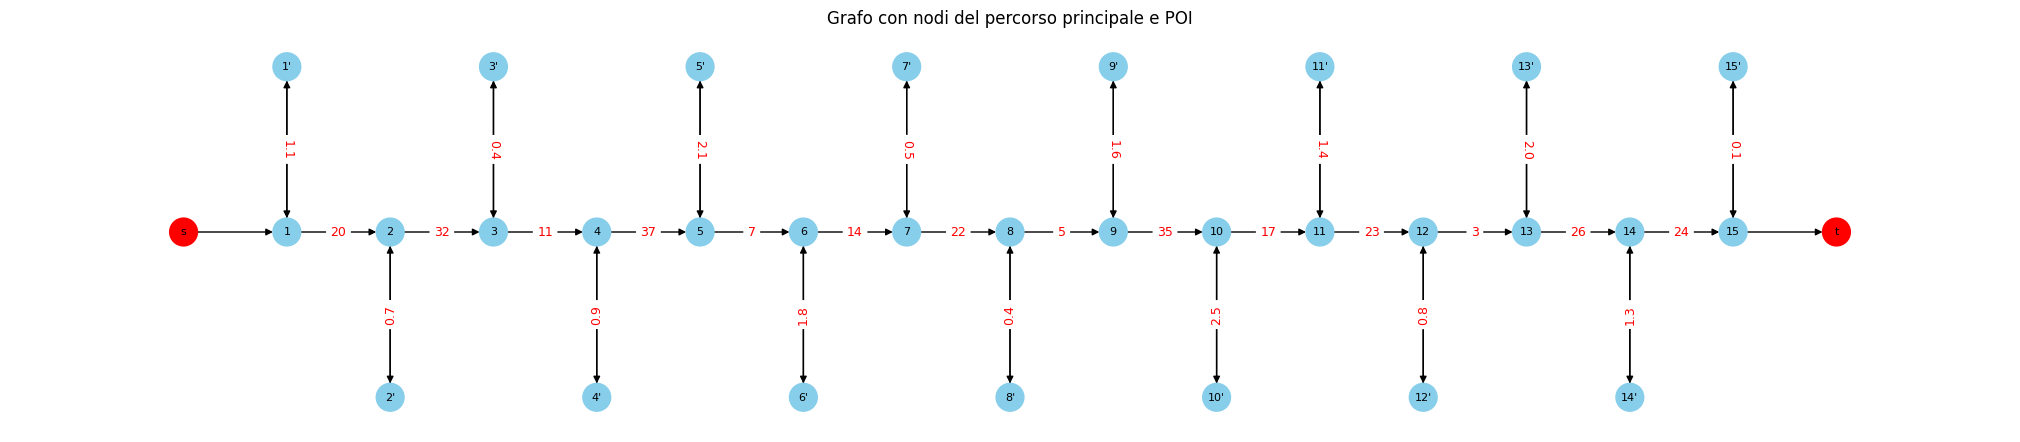

In [4]:
# BUILD THE EQUIVALENT GRAPH
import matplotlib.pyplot as plt

#define the set of nodes
L = [i for i in range(s+1, t)]  # insieme di nodi del percorso principale
H = [f"{i}'" for i in L]  # un punto di interesse per ogni nodo che esiste
E = [s, t]  # estremi della pista ciclabile
nodes = E + L + H  # insieme di nodi totali

#define the set of edges
A = [(i, i+1) for i in range(s, t)]  # insieme di archi da s a t
Ad = [(i, f"{i}'") for i in range(s+1, t)]  # insieme di archi delle deviazioni (da i a i')

# Crea un grafo orientato vuoto
G = nx.DiGraph()

# Definisce la dimensione della griglia
grid_width = 200
grid_height = 40

# Calcola l'offset per i POI
d_y = 0.3 * grid_height

# Assegna le coordinate x,y dei nodi del percorso principale rispetto alla griglia
points_main_path = np.array([[i * grid_width / (t - 2), grid_height / 2] for i in range(t-1)])

# Assegna le coordinate x,y dei POI rispetto alla griglia
poi = np.array([[points_main_path[i, 0], points_main_path[i, 1] + d_y if i % 2 == 0 else points_main_path[i, 1] - d_y] for i in range(t-1)])

# Assegna le coordinate x,y dei nodi s e t
start_point = np.array([(s-1) * grid_width / (t - 2), grid_height / 2])
end_point = np.array([(t-1) * grid_width / (t - 2), grid_height / 2])

# Aggiunge i nodi del percorso principale al grafo
for i in range(s, t-1):
    G.add_node(f"{i+1}", pos=(points_main_path[i, 0], points_main_path[i, 1]))
    G.add_node(f"{i+1}'", pos=(poi[i, 0], poi[i, 1]))

# Aggiunge i nodi s e t al grafo
G.add_node('s', pos=(start_point[0], start_point[1]))
G.add_node('t', pos=(end_point[0], end_point[1]))

# Aggiunge gli archi tra i POI e i nodi del percorso principale (in entrambe le direzioni)
for i in range(s, t-1):
    G.add_weighted_edges_from([(f"{i+1}'", f"{i+1}", consumption_deviation[i])])
    G.add_weighted_edges_from([(f"{i+1}", f"{i+1}'", consumption_deviation[i])])

# Aggiunge gli archi tra i nodi del percorso principale con i pesi basati sul consumo
for i in range(s, t - 2):
    G.add_weighted_edges_from([(f"{i+1}", f"{i+2}", consumption[i])])

# Aggiungi gli archi tra il nodo s e s+1, e tra il nodo t-1 e t
G.add_edge('s', f"{s+1}")
G.add_edge(f"{t-1}", 't')

# Estrae le posizioni dei nodi
pos = nx.get_node_attributes(G, 'pos')

# Variabile colori nodi
node_colors = ['red' if node in ['s', 't'] else 'skyblue' for node in G.nodes()]

# Disegna il grafo
plt.figure(figsize=(20, 4))  # Imposta l'ampiezza del grafico su 20 e l'altezza su 4
nx.draw(G, pos, with_labels=False, node_size=400, node_color=node_colors, arrows=True)
node_labels = nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, verticalalignment='center', font_size=8)

# Disegna i pesi sugli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color='red')

#titolo grafo
plt.title('Grafo con nodi del percorso principale e POI')
plt.show()


#aggiunte utili per il modello
d = {} # Dizionario che associa ad ogni arco il suo consumo

d[(s, s+1)] = 0  # arco da s al successivo ha consumo zero in quanto s è un nodo fittizio
d[(t-1, t)] = 0  # arco dall'ultimo nodo a t ha consumo zero in quanto t è un nodo fittizio

for i in range(s+1, t-1):
    d[(i, i + 1)] = consumption[i - 1]  # per i restanti archi del percorso principale utilizzo i relativi consumi dei dati

for i in range(s+1, t):
    d[(i, f"{i}'")] = consumption_deviation[i - 1]  # per le deviazioni associo i relativi consumi delle deviazioni

c_stazione = {f"{i}'": inst_cost[i - 1] for i in range(s+1, t)}  # dizionario che associa ad ogni POI il costo di installazione di una eventuale stazione di ricarica

In [5]:
import mip
# CREATE MODEL

m = mip.Model(sense=mip.MINIMIZE)

# DEFINE THE VARIABLE

x = {h: m.add_var(var_type=mip.BINARY) for h in H} #definisco una variabile per ogni punto di interesse: assume valore 1 se installo stazione di ricarica 0 altrimenti

y = {h: m.add_var() for h in H} #autonomia con la quale parto da un POI (che cambia se installo la stazione di ricarica o meno)

z = {h: m.add_var() for h in H} #autonomia con la quale arrivo al POI

p={} #dizionario che associa alla tupla (POI, POI_successivo) il consumo di quella tratta

p[(f"{s}'", f"{s+1}'")] = consumption_deviation[s] #da s a s+1' è un caso particolare in quanto il consumo coincide con il solo consumo della prima deviazione
p[(f"{t-1}'", f"{t}'")] = consumption_deviation[t-2] #da t-1 a t-1' è un caso particolare in quanto il consumo coincide con il solo consumo dell'ultima deviazione

#in tutti gli altri casi il consumo da un POI al successivo è il seguente
for i in range(s+1, t-1):
    p[(f"{i}'", f"{i+1}'")] = consumption_deviation[i - 1] + consumption[i - 1] + consumption_deviation[i]

# DEFINE THE CONSTRAINTS

m.add_constr(z[f"{s+1}'"]==delta-p[((f"{s}'", f"{s+1}'"))]) #vincolo sul primo tratto di percorso per mostrare che il ciclista parte con autonomia delta

#vincoli su ogni POI : autonomia in arrivo a un POI = autonomia di partenza dal POI precedente - il consumo della tratta
for j in range(s+2,t-1):
  j_current = f"{j}'"
  j_prec = f"{j-1}'"
  m.add_constr(z[j_current]==y[j_prec]-p[(j_prec,j_current)])

for i in range(s+1, t-1):
    h_current = f"{i}'"
    h_next = f"{i+1}'"
    m.add_constr(y[h_current] <= delta) #autonomia di partenza da un POI non può mai essere maggiore di delta
    m.add_constr(y[h_current]>=z[h_current])  #autonomia di partenza da un POI non può mai essere minore di quella di arrivo
    m.add_constr(y[h_current] - p[(h_current, h_next)] >= (delta - p[(h_current, h_next)]) * x[h_current]) #vincolo per assicurare che l'autonomia di partenza da un POI permetta di arrrivare al POI successivo in ogni caso
    m.add_constr(y[h_current]-z[h_current]<=delta*x[h_current]) #vincolo per assicurare che se il ciclista non ricarica l'autonomia con cui parte da un POI è uguale a quella con cui è arrivato a quel POI

# MINIMIZE THE COST OF INSTALLATION
m.objective = mip.xsum(c_stazione[h] * x[h] for h in H)

# OTTIMIZZA
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [6]:
print(m.objective_value)

12348.0


Stazione installata al POI 2'
Stazione installata al POI 4'
Stazione installata al POI 5'
Stazione installata al POI 7'
Stazione installata al POI 8'
Stazione installata al POI 10'
Stazione installata al POI 12'
Stazione installata al POI 14'


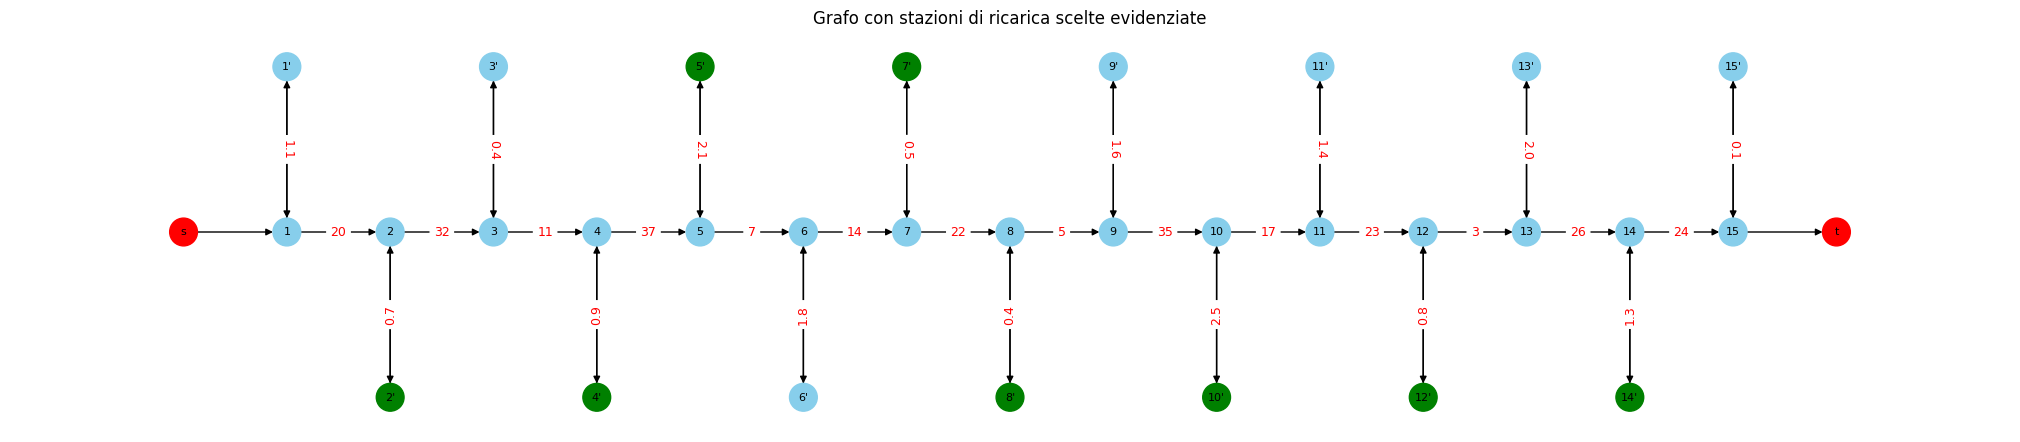

In [7]:
# PRINT THE PATH, VISUALIZE IT WITH A FIGURE

for h in H:
  if x[h].x == 1:
    print(f"Stazione installata al POI {h}")

# variabili colori dei nodi
node_colors = []
for node in G.nodes():
    if node in ['s', 't']:
        node_colors.append('red')
    elif node in x and x[node].x == 1:
        node_colors.append('green')
    else:
        node_colors.append('skyblue')
# Disegna il grafo
plt.figure(figsize=(20, 4))  # Imposta l'ampiezza del grafico su 20 e l'altezza su 4
nx.draw(G, pos, with_labels=False, node_size=400, node_color=node_colors, arrows=True)
node_labels = nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, verticalalignment='center', font_size=8)

# Disegna i pesi sugli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color='red')

plt.title('Grafo con stazioni di ricarica scelte evidenziate')
plt.show()

## Solution Problem 2

In [8]:
#data PROBLEM 2

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point-> coincide con la destinazione di prima
t = n+1  # destination-> coincide con l'inizio di prima
consumption = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation


#to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it

inst_cost = [inst_cost[-i] for i in range(1,n1+1)]


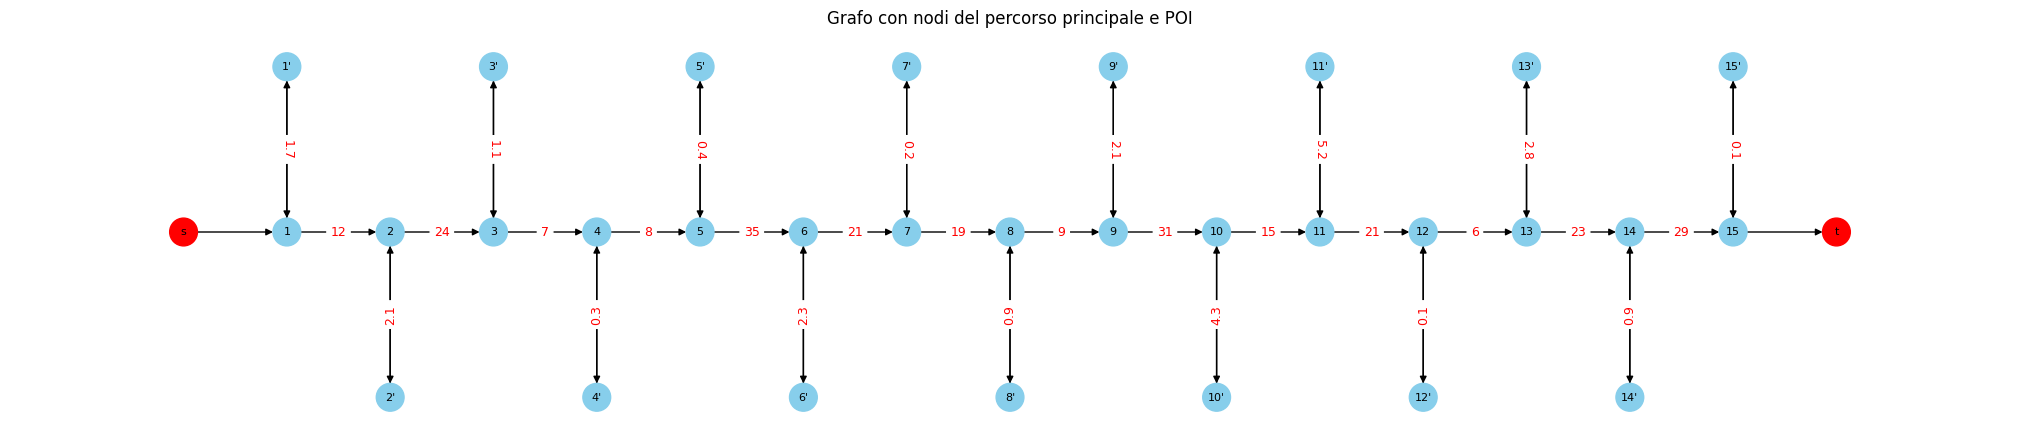

In [10]:
# BUILD THE EQUIVALENT GRAPH
import matplotlib.pyplot as plt

#define the set of nodes
L = [i for i in range(s+1, t)]  # insieme di nodi del percorso principale
H = [f"{i}'" for i in L]  # un punto di interesse per ogni nodo che esiste
E = [s, t]  # estremi della pista ciclabile
nodes = E + L + H  # insieme di nodi totali

#define the set of edges
A = [(i, i+1) for i in range(s, t)]  # insieme di archi da s a t
Ad = [(i, f"{i}'") for i in range(s+1, t)]  # insieme di archi delle deviazioni (da i a i')

# Crea un grafo orientato vuoto
G = nx.DiGraph()

# Definisce la dimensione della griglia
grid_width = 200
grid_height = 40

# Calcola l'offset per i POI
d_y = 0.3 * grid_height

# Assegna le coordinate x,y dei nodi del percorso principale rispetto alla griglia
points_main_path = np.array([[i * grid_width / (t - 2), grid_height / 2] for i in range(t-1)])

# Assegna le coordinate x,y dei POI rispetto alla griglia
poi = np.array([[points_main_path[i, 0], points_main_path[i, 1] + d_y if i % 2 == 0 else points_main_path[i, 1] - d_y] for i in range(t-1)])

# Assegna le coordinate x,y dei nodi s e t
start_point = np.array([(s-1) * grid_width / (t - 2), grid_height / 2])
end_point = np.array([(t-1) * grid_width / (t - 2), grid_height / 2])

# Aggiunge i nodi del percorso principale al grafo
for i in range(s, t-1):
    G.add_node(f"{i+1}", pos=(points_main_path[i, 0], points_main_path[i, 1]))
    G.add_node(f"{i+1}'", pos=(poi[i, 0], poi[i, 1]))

# Aggiunge i nodi s e t al grafo
G.add_node('s', pos=(start_point[0], start_point[1]))
G.add_node('t', pos=(end_point[0], end_point[1]))

# Aggiunge gli archi tra i POI e i nodi del percorso principale (in entrambe le direzioni)
for i in range(s, t-1):
    G.add_weighted_edges_from([(f"{i+1}'", f"{i+1}", consumption_deviation[i])])
    G.add_weighted_edges_from([(f"{i+1}", f"{i+1}'", consumption_deviation[i])])

# Aggiunge gli archi tra i nodi del percorso principale con i pesi basati sul consumo
for i in range(s, t - 2):
    G.add_weighted_edges_from([(f"{i+1}", f"{i+2}", consumption[i])])

# Aggiungi gli archi tra il nodo s e s+1, e tra il nodo t-1 e t
G.add_edge('s', f"{s+1}")
G.add_edge(f"{t-1}", 't')

# Estrae le posizioni dei nodi
pos = nx.get_node_attributes(G, 'pos')

# Variabile colori nodi
node_colors = ['red' if node in ['s', 't'] else 'skyblue' for node in G.nodes()]

# Disegna il grafo
plt.figure(figsize=(20, 4))  # Imposta l'ampiezza del grafico su 20 e l'altezza su 4
nx.draw(G, pos, with_labels=False, node_size=400, node_color=node_colors, arrows=True)
node_labels = nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, verticalalignment='center', font_size=8)

# Disegna i pesi sugli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color='red')

#titolo grafo
plt.title('Grafo con nodi del percorso principale e POI')
plt.show()


#aggiunte utili per il modello
d = {} # Dizionario che associa ad ogni arco il suo consumo

d[(s, s+1)] = 0  # arco da s al successivo ha consumo zero in quanto s è un nodo fittizio
d[(t-1, t)] = 0  # arco dall'ultimo nodo a t ha consumo zero in quanto t è un nodo fittizio

for i in range(s+1, t-1):
    d[(i, i + 1)] = consumption[i - 1]  # per i restanti archi del percorso principale utilizzo i relativi consumi dei dati

for i in range(s+1, t):
    d[(i, f"{i}'")] = consumption_deviation[i - 1]  # per le deviazioni associo i relativi consumi delle deviazioni

c_stazione = {f"{i}'": inst_cost[i - 1] for i in range(s+1, t)}  # dizionario che associa ad ogni POI il costo di installazione di una eventuale stazione di ricarica

In [11]:
import mip
# CREATE MODEL

m = mip.Model(sense=mip.MINIMIZE)

# DEFINE THE VARIABLE

x = {h: m.add_var(var_type=mip.BINARY) for h in H} #definisco una variabile per ogni punto di interesse: assume valore 1 se installo stazione di ricarica 0 altrimenti

y = {h: m.add_var() for h in H} #autonomia con la quale parto da un POI (che cambia se installo la stazione di ricarica o meno)

z = {h: m.add_var() for h in H} #autonomia con la quale arrivo al POI

p={} #dizionario che associa alla tupla (POI, POI_successivo) il consumo di quella tratta

p[(f"{s}'", f"{s+1}'")] = consumption_deviation[s] #da s a s+1' è un caso particolare in quanto il consumo coincide con il solo consumo della prima deviazione
p[(f"{t-1}'", f"{t}'")] = consumption_deviation[t-2] #da t-1 a t-1' è un caso particolare in quanto il consumo coincide con il solo consumo dell'ultima deviazione

#in tutti gli altri casi il consumo da un POI al successivo è il seguente
for i in range(s+1, t-1):
    p[(f"{i}'", f"{i+1}'")] = consumption_deviation[i - 1] + consumption[i - 1] + consumption_deviation[i]

# DEFINE THE CONSTRAINTS

m.add_constr(z[f"{s+1}'"]==delta-p[((f"{s}'", f"{s+1}'"))]) #vincolo sul primo tratto di percorso per mostrare che il ciclista parte con autonomia delta

#vincoli su ogni POI : autonomia in arrivo a un POI = autonomia di partenza dal POI precedente - il consumo della tratta
for j in range(s+2,t-1):
  j_current = f"{j}'"
  j_prec = f"{j-1}'"
  m.add_constr(z[j_current]==y[j_prec]-p[(j_prec,j_current)])

for i in range(s+1, t-1):
    h_current = f"{i}'"
    h_next = f"{i+1}'"
    m.add_constr(y[h_current] <= delta) #autonomia di partenza da un POI non può mai essere maggiore di delta
    m.add_constr(y[h_current]>=z[h_current])  #autonomia di partenza da un POI non può mai essere minore di quella di arrivo
    m.add_constr(y[h_current] - p[(h_current, h_next)] >= (delta - p[(h_current, h_next)]) * x[h_current]) #vincolo per assicurare che l'autonomia di partenza da un POI permetta di arrrivare al POI successivo in ogni caso
    m.add_constr(y[h_current]-z[h_current]<=delta*x[h_current]) #vincolo per assicurare che se il ciclista non ricarica l'autonomia con cui parte da un POI è uguale a quella con cui è arrivato a quel POI

# MINIMIZE THE COST OF INSTALLATION
m.objective = mip.xsum(c_stazione[h] * x[h] for h in H)

# OTTIMIZZA
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [12]:
print(m.objective_value)

12924.0


Stazione installata al POI 3'
Stazione installata al POI 4'
Stazione installata al POI 6'
Stazione installata al POI 8'
Stazione installata al POI 10'
Stazione installata al POI 11'
Stazione installata al POI 12'
Stazione installata al POI 14'


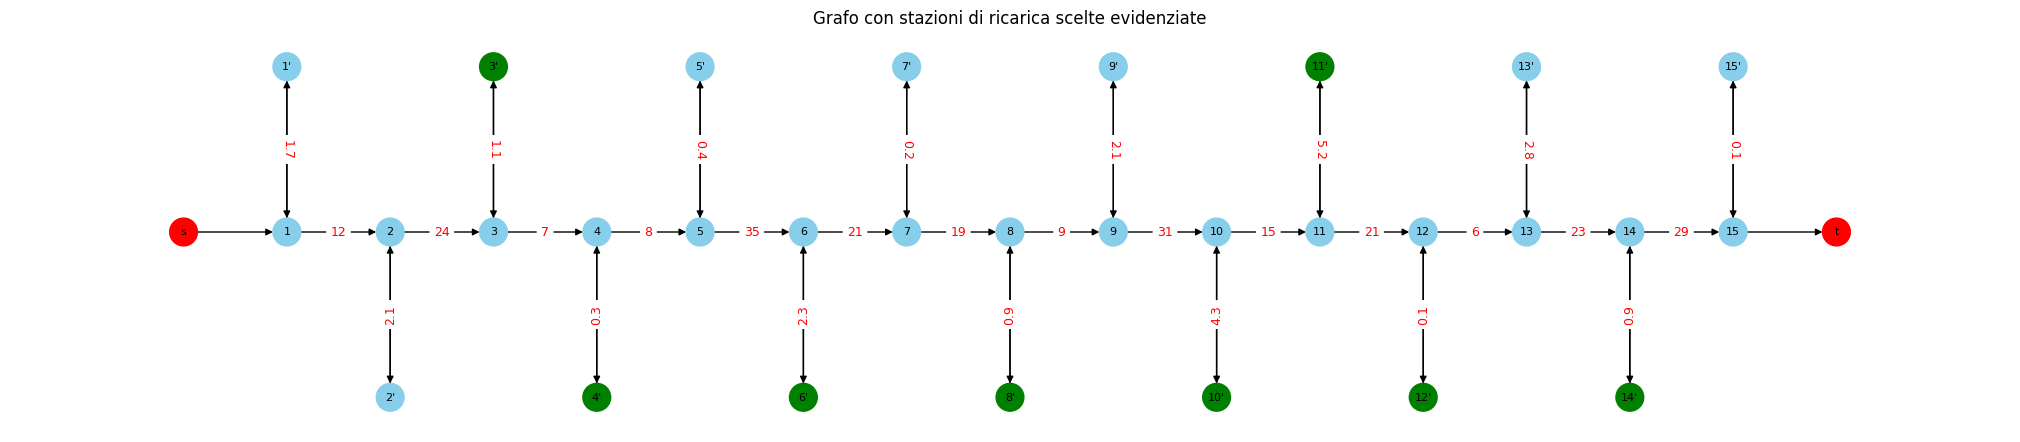

In [13]:
# PRINT THE PATH, VISUALIZE IT WITH A FIGURE

for h in H:
  if x[h].x == 1:
    print(f"Stazione installata al POI {h}")

# variabili colori dei nodi
node_colors = []
for node in G.nodes():
    if node in ['s', 't']:
        node_colors.append('red')
    elif node in x and x[node].x == 1:
        node_colors.append('green')
    else:
        node_colors.append('skyblue')
# Disegna il grafo
plt.figure(figsize=(20, 4))  # Imposta l'ampiezza del grafico su 20 e l'altezza su 4
nx.draw(G, pos, with_labels=False, node_size=400, node_color=node_colors, arrows=True)
node_labels = nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, verticalalignment='center', font_size=8)

# Disegna i pesi sugli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color='red')

plt.title('Grafo con stazioni di ricarica scelte evidenziate')
plt.show()

## Comment

Do you obtain the same solution? Why?

Osservando i valori delle funzioni obbiettivo stampate e i POI nei quali sono state installate le stazioni di ricarica nei due problemi, è facile notare che le soluzioni ottime per le due casistiche sono differenti. Nel percorso di andata abbiamo ottenuto un insieme di stazioni di ricarica differente da quello del ritorno, più nello specifico il costo totale delle stazioni per il percorso ribaltato risulta maggiore rispetto a quello del percorso originale. Questa differenza è probabilmente dovuta ai seguenti fattori:
- paragonando banalmente i consumi del problema 1 con quelli del problema 2 (sia del percorso principale che delle deviazioni) notiamo che questi non sono semplicemente invertiti come i costi di installazione, tuttavia cambiano radicalmente da un caso all'altro. Questa caratteristica è spiegabile con un'assunzione realistica: le tratte da percorrere lungo la ciclovia hanno una determinata pendenza e perciò l'utilizzo della componente elettrica della bici da parte del ciclista varia a seconda che si imbatta in una discesa o in una salita.
Per esemplificare il concetto si prenda come riferimento l'arco dal nodo 14 al 15 all'andata e quello dal 1 al 2 al ritorno (ovvero lo stesso arco). Il consumo di questa tratta all'andata (e quindi il peso dell'arco) è il doppio di quello del ritorno, probabilmente in quanto questa è in salita nel primo problema e in discesa nel secondo, o alternativamente il ciclista è più stanco fisicamente quando è quasi alla fine del percorso mentre è più fresco quando è appena partito.

- Interpretando in modo più teorico la questione, a livello di programmazione lineare i due problemi hanno diversi coefficienti delle variabili (matrice A) e diversi termini noti (b), nonostante condividano la stessa funzione obbiettivo e le stesse variabili. Questo fa si che la regione ammissibile di un problema rispetto a quella dell'altro cambi e di conseguenza vada ad includere nuove soluzioni ammissibili o ad eliminare quelle vecchie. Come possiamo intuire, nel problema 2 la soluzione ottima del problema 1 è stata scartata in quanto non più ammissibile e si è trovata una soluzione ottima peggiore rispetto alla prima.

Write here your comment...



